In [174]:
import numpy as np
import pandas as pd
#import scipy
from scipy.special import binom
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# from scipy.stats import quantile
# from itertools import combinations

# Load source_ACR module
# Assuming the relevant functions are defined in source_ACR_py.py
import source_ACR_py as acr

# Initialization
thres_acr = 0.05 # it seems good
thres_positive = 0.1 # it seems reasonable but sometimes unappropriate
thres_unbounded = 0.1 # it seems reasonable but sometimes unappropriate
num_S = 2
max_order = 2
num_R = 2
source_mat = None
product_mat = None
stoi_mat = None

num_total_C = int(binom(max_order + num_S, num_S))
total_complex = acr.make_total_complexes(num_S, max_order)

num_total_R = num_total_C * (num_total_C - 1)
num_total_net = int(binom(num_total_R, num_R))

num_repeat_par = 7
num_repeat_init = 20

In [340]:
# Beginning of the random network search
list_acr_id = np.zeros(num_S, dtype=int)
list_unbnd_id = np.zeros(num_S, dtype=int)

rnd_search = False
net_id = 422
print(f"======= Analyzing network {net_id:4} =======")
list_R_id = acr.net_id_to_R_id_list(net_id, num_total_R, num_R)
list_source_id, list_product_id = zip(*[acr.reaction_id_to_complex_id(R_id, num_total_C) for R_id in list_R_id])
source_mat = total_complex[:, np.array(list_source_id)-1]
product_mat = total_complex[:, np.array(list_product_id)-1]
stoi_mat = product_mat - source_mat

# Simulation settings
tspan1 = (0.0, 50.0)

ub_param = 10 * np.ones(num_R) # Lower bounds for the parameter values
lb_param = np.zeros(num_R) # Upper bounds for the parameter values

ub_init = 20 * np.ones(num_S) # Lower bounds for the initial values
lb_init = np.ones(num_S) # Upper bounds for the initial values

list_acr_id_par = np.zeros((num_S, num_repeat_par), dtype=int)
list_unbnd_id_par = np.zeros((num_S, num_repeat_par), dtype=int)

upp_val = np.zeros((num_S, num_repeat_par))
low_val = np.zeros((num_S, num_repeat_par))
kappa1 = np.zeros((num_R, num_repeat_par))

for iter_par in range(num_repeat_par):
    kappa1[:, iter_par] = np.random.uniform(low=lb_param, high=ub_param, size=num_R)
    final_val_mat = np.zeros((num_S, num_repeat_init))
    latter_val_mat = np.zeros((num_S, num_repeat_init))

    for iter_init in range(1, num_repeat_init + 1):
        x_init = np.random.uniform(low=lb_init, high=ub_init, size=num_S)
        t_eval = np.arange(tspan1[0], tspan1[1]+1, 1)
        sol1 = solve_ivp(acr.MAK_rescaled, tspan1, x_init, args = (kappa1[:, iter_par], source_mat, stoi_mat), method='RK45', t_eval=t_eval)
        sol_mat1 = sol1.y.T
        length_tspan = sol_mat1.shape[0]
        final_val_mat[:, iter_init - 1] = sol_mat1[length_tspan - 1, :]

        if int(np.floor(0.8 * length_tspan)) >= 1:
            latter_val_mat[:, iter_init - 1] = sol_mat1[int(np.floor(0.8 * length_tspan)), :]

    upp_val[:,iter_par] = np.array([np.quantile(final_val_mat[i, :], 0.6) for i in range(num_S)])
    low_val[:,iter_par] = np.array([np.quantile(final_val_mat[i, :], 0.4) for i in range(num_S)])

    for i in range(num_S):
        if upp_val[i,iter_par] - low_val[i,iter_par] < thres_acr and low_val[i,iter_par] > thres_positive:
            list_acr_id_par[i, iter_par] = 1
        if np.mean(latter_val_mat[i, :]) > lb_init[i] and np.mean(final_val_mat[i, :]) > np.mean(latter_val_mat[i, :]) + thres_unbounded:
            list_unbnd_id_par[i, iter_par] = 1

for i in range(num_S):
    if np.sum(list_acr_id_par[i, :]) > 0:
        list_acr_id[i] += 1
    if np.prod(list_acr_id_par[i, :]) > 0:
        list_acr_id[i] += 1
    if np.sum(list_unbnd_id_par[i, :]) > 0:
        list_unbnd_id[i] += 1
    if np.prod(list_unbnd_id_par[i, :]) > 0:
        list_unbnd_id[i] += 1
    
print(f"======= DONE =======")

======= Analyzing network  422 =======
======= DONE =======


In [351]:
print(acr.crn_writing(source_mat, product_mat)[1])
print("latter_val_mat:")
print(np.round(latter_val_mat[:, range(12)], 1))
print("final_val_mat:")
print(np.round(final_val_mat[:, range(12)], 1))
print("difference_mat:")
print(np.round(final_val_mat[:, range(12)]-latter_val_mat[:, range(12)], 1))

print("\nupp_val")
print(np.round(upp_val, 3))
print("low_val")
print(np.round(low_val, 3))
print("diff_val")
print(np.round(upp_val - low_val, 3))

print("\nlist_acr_id_par:")
print(list_acr_id_par)
print("list_unbnd_id_par:")
print(list_unbnd_id_par)
print("list_acr_id:")
print(list_acr_id)
print("list_unbnd_id:")
print(list_unbnd_id)

print("\nkappa")
print(kappa1)

['A+B -> 2B', '2B -> A']
latter_val_mat:
[[0.1 0.  0.1 0.  0.  0.1 0.  0.  0.  0.  0.1 0.1]
 [0.1 0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.1]]
final_val_mat:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
difference_mat:
[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]]

upp_val
[[ 1.3000e-02  1.8000e-02  8.0000e-03  1.7000e-02  3.0590e+01  1.8000e-02
   3.6000e-02]
 [ 1.2000e-02  1.5000e-02  1.3000e-02  1.2000e-02 -2.6343e+01  3.8000e-02
   3.3000e-02]]
low_val
[[ 1.2000e-02  1.6000e-02  7.0000e-03  1.5000e-02  2.8306e+01  1.7000e-02
   3.4000e-02]
 [ 1.0000e-02  1.3000e-02  1.2000e-02  1.1000e-02 -3.0158e+01  3.5000e-02
   3.2000e-02]]
diff_val
[[2.000e-03 2.000e-03 0.000e+00 2.000e-03 2.284e+00 1.000e-03 1.000e-03]
 [1.000e-03 2.000e-03 1.000e-03 1.000e-03 3.814e+00 3.000e-03 1.000e-03]]

list_acr_id_par:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
list_unbnd_id_par:
[[0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]]
list_

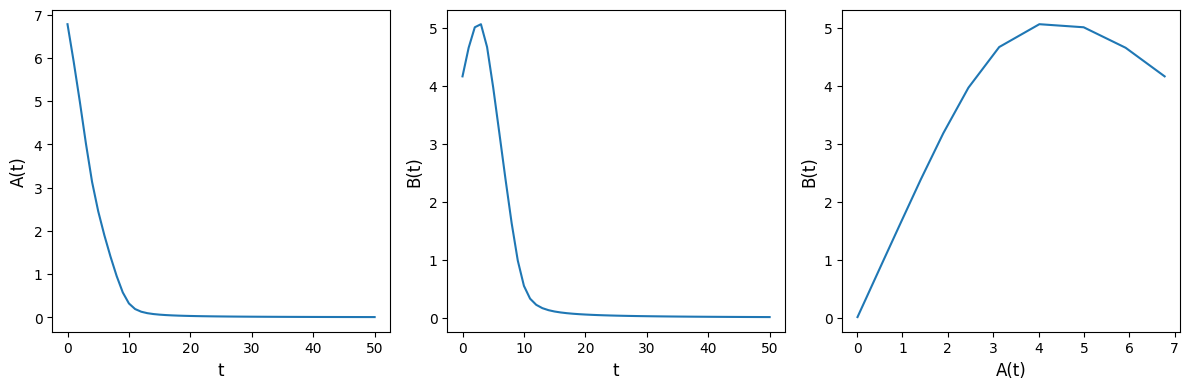

In [350]:
x_init_tmp = [17.87859346, 9.25049512] # np.random.uniform(low=lb_init, high=ub_init, size=num_S)
x_init_tmp = np.random.uniform(low=lb_init, high=ub_init, size=num_S)
kappa_tmp = [3.36308509, 9.89004494]
kappa_tmp = np.random.uniform(low=lb_param, high=ub_param, size=num_R)
tbin = 1
t_eval_tmp = np.arange(tspan1[0], tspan1[1]+tbin, tbin)
sol_tmp = solve_ivp(acr.MAK_rescaled, tspan1, x_init_tmp, args = (kappa_tmp, source_mat, stoi_mat), method='RK45', t_eval=t_eval_tmp)
#sol_tmp = solve_ivp(acr.MAK_rescaled, tspan1, x_init_tmp, args = (kappa_tmp, source_mat, stoi_mat), method='RK45')
#sol_tmp = sol1
fig, ax = plt.subplots(1,3,figsize = (12, 4))

fontSize = 12
ax[0].plot(sol_tmp.t, sol_tmp.y[0])
ax[0].set_xlabel('t', fontsize = fontSize)
ax[0].set_ylabel('A(t)', fontsize = fontSize)
#ax[0].margins(0)

ax[1].plot(sol_tmp.t, sol_tmp.y[1])
ax[1].set_xlabel('t', fontsize = fontSize)
ax[1].set_ylabel('B(t)', fontsize = fontSize)

ax[2].plot(sol_tmp.y[0], sol_tmp.y[1])
ax[2].set_xlabel('A(t)', fontsize = fontSize)
ax[2].set_ylabel('B(t)', fontsize = fontSize)

#plt.subplots_adjust(vspace=3)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.show()